In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:

    # Model characteristics
    compartments = ("Susceptible", "Pre-infectious", "Infectious", "Immune")
    model = CompartmentalModel(
        times=(0., config["end_time"] * 365.),
        compartments=compartments,
        infectious_compartments=["Infectious"],
        timestep=config["t_step"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["tot_popn"] - config["infous_0"],
            "Infectious": config["infous_0"],
        }
    )
    
    # Transitions
    r0 = Parameter("r0")
    ave_infous = Parameter("ave_infous")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=r0 / ave_infous,
        source="Susceptible", 
        dest="Pre-infectious",
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("ave_preinfous"),
        source="Pre-infectious", 
        dest="Infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / ave_infous,
        source="Infectious", 
        dest="Immune",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / Parameter("life_expectancy") / 365.,
    )
    model.add_replacement_birth_flow(
        "births",
        "Susceptible",
    )

    # Outputs
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression"
    )
    model.request_output_for_compartments(
        name="total_population",
        compartments=compartments,
        save_results=False,
    )
    model.request_output_for_compartments(
        name="susceptible",
        compartments=("Susceptible",),
        save_results=False,
    )
    model.request_output_for_compartments(
        name="immune",
        compartments=("Immune",),
        save_results=False,
    )
    total_population = DerivedOutput("total_population")
    model.request_function_output(
        name="susc_prop",
        func=DerivedOutput("susceptible") / total_population,
    )
    model.request_function_output(
        name="immune_prop",
        func=DerivedOutput("immune") / total_population,
    )    
    model.request_function_output(
        name="r_n",
        func=DerivedOutput("susc_prop") * r0,
    )
    
    return model

In [3]:
model_config = {
    "tot_popn": 1e5,
    "infous_0": 2.,
    "end_time": 120.,
    "t_step": 1.,
    "prop_immune_0": 0.3,
    "end_time": 100.,
}

parameters = {
    "r0": 13.,
    "ave_preinfous": 8.,
    "ave_infous": 7.,
    "life_expectancy": 70.,
}

In [4]:
seir_demog_model = build_seir_model(model_config)
seir_demog_model.run(parameters=parameters)
compartment_values = seir_demog_model.get_outputs_df()
derived_outputs = seir_demog_model.get_derived_outputs_df()

#### Unnumbered figure on the left

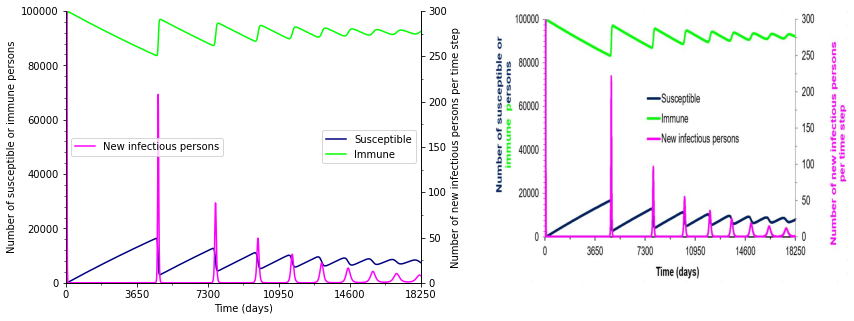

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(
    seir_demog_model.times, 
    compartment_values["Susceptible"], 
    color="navy",
    label="Susceptible",
)
left_ax.plot(
    seir_demog_model.times,
    compartment_values["Immune"],
    color="lime",
    label="Immune",
)
left_ax.set_xlim(0., 18250.)
left_ax.set_xticks(range(0, 21900, 3650))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(2))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0., 1e5)
left_ax.set_ylabel("Number of susceptible or immune persons")
left_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.legend()
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    seir_demog_model.times, 
    seir_demog_model.derived_outputs["incidence"], 
    color="magenta", 
    label="New infectious persons",
)
twin_ax.set_ylim(0., 300.)
twin_ax.set_ylabel("Number of new infectious persons per time step")
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
twin_ax.legend(loc=6)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_4_3a_fig.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

#### Figure 1

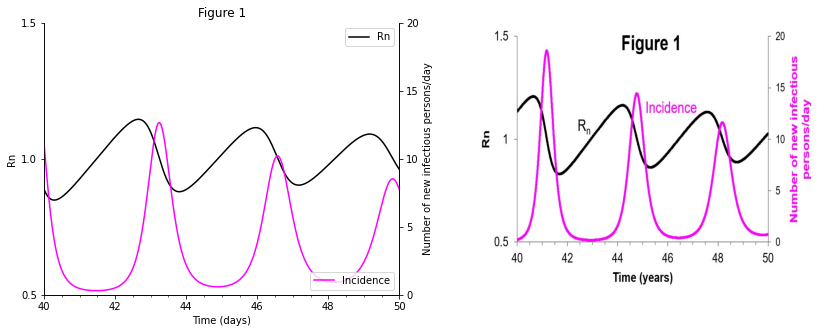

In [6]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

times = seir_demog_model.times / 365.

left_ax.plot(
    times, 
    derived_outputs["r_n"], 
    color="k", 
    label="Rn",
)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0.5, 1.5)
left_ax.set_yticks(np.linspace(0.5, 1.5, 3))
left_ax.set_ylabel("Rn")
left_ax.legend()
left_ax.set_title("Figure 1")
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    times, 
    derived_outputs["incidence"], 
    color="magenta", 
    label="Incidence",
)
twin_ax.set_xlim(40., 50.)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.set_ylim(0., 20.)
twin_ax.set_ylabel("Number of new infectious persons/day")
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_4_3a_fig_1.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

#### Figure 2 (marked as 3)

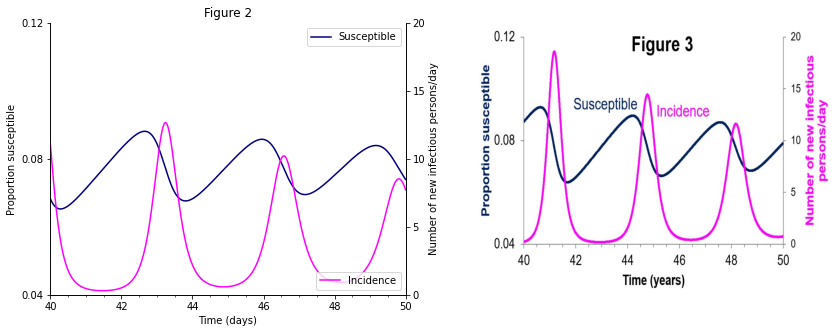

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

times = seir_demog_model.times / 365.
left_ax.plot(times, derived_outputs["susc_prop"], color="navy", label="Susceptible")
left_ax.set_xlabel("Time (days)")
left_ax.xaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.set_ylim(0.04, 0.12)
left_ax.set_yticks(np.linspace(0.04, 0.12, 3))
left_ax.set_ylabel("Proportion susceptible")
left_ax.legend()
left_ax.spines.top.set_visible(False)
left_ax.set_title("Figure 2")

twin_ax = left_ax.twinx()
twin_ax.plot(times, derived_outputs["incidence"], color="magenta", label="Incidence")
twin_ax.set_xlim(40, 50)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.set_ylim(0, 20)
twin_ax.set_ylabel("Number of new infectious persons/day")
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_4_3a_fig_2.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

### Figure 3

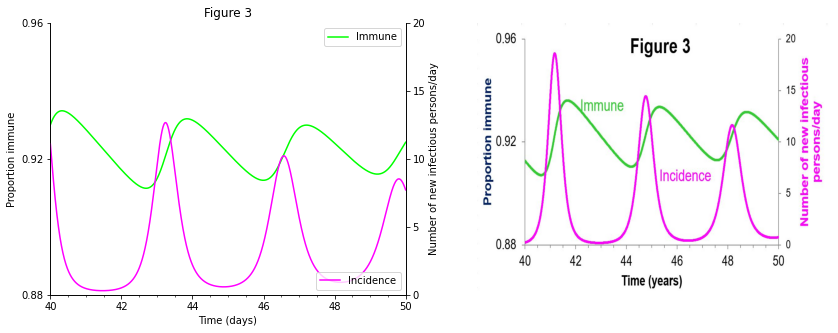

In [8]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

times = seir_demog_model.times / 365.

left_ax.plot(
    times, 
    derived_outputs["immune_prop"], 
    color="lime", 
    label="Immune",
)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0.88, 0.96)
left_ax.set_yticks(np.linspace(0.88, 0.96, 3))
left_ax.set_ylabel("Proportion immune")
left_ax.legend()
left_ax.set_title("Figure 3")
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    times, 
    derived_outputs["incidence"],
    color="magenta",
    label="Incidence",
)
twin_ax.set_xlim(40., 50.)
twin_ax.set_ylim(0., 20.)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.set_ylabel("Number of new infectious persons/day")
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_4_3a_fig_3.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");